# Exploration of histone marks signal

In this notebook, we explore the data extracted from different histone marks and their relationship with loops.

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seqloops.config import data_dir

In [2]:
loops = pickle.load(open(data_dir / 'out/loops_merged.pkl', 'rb'))

In [3]:
histones = loops.drop(columns=['chrom', 'start', 'end', 'seq', 'status'])
marks = histones.columns
X = histones.applymap(np.mean)

A few histone marks such as H2as123ph, H3K4Me3 or H3K36Me3 stand out as different between loops and non loops.

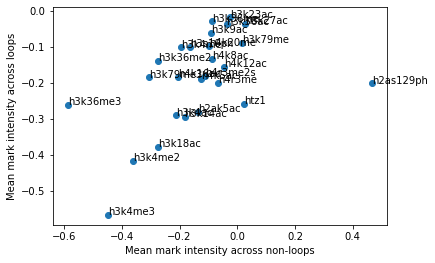

In [4]:
%matplotlib inline
fig, ax = plt.subplots()
avg_loops = X.loc[loops.status == 1, :].mean(axis=0)
avg_control = X.loc[loops.status == 0, :].mean(axis=0)
ax.scatter(avg_control, avg_loops)
ax.set_xlabel("Mean mark intensity across non-loops")
ax.set_ylabel("Mean mark intensity across loops")

for i, mark in enumerate(marks):
    ax.annotate(mark, (avg_control[i], avg_loops[i]))

We'll compute a few summary statistics of histone coverage for each sequence and use these as features.

In [5]:
# Let's add other features from the same histone marks
from sklearn.preprocessing import StandardScaler
X = pd.concat([histones.applymap(np.mean), histones.applymap(max), histones.applymap(min)], axis=1)
y = loops.status

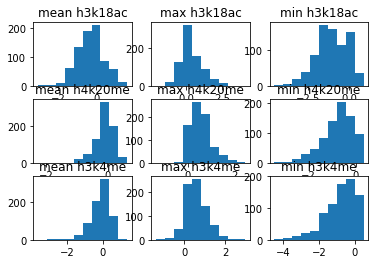

In [10]:
%matplotlib inline
# Checking the distribution of new features
n_marks = histones.shape[1]
sel_marks = 3
fig, ax = plt.subplots(sel_marks, 3)
for i, op in enumerate(['mean', 'max', 'min']):
    mark_idx = [x + i * n_marks for x in range(sel_marks)]
    for j, idx in enumerate(mark_idx):
        ax[j, i].hist(X.iloc[:, idx])
        ax[j, i].set_title(f'{op} {marks[j]}')
plt.show()

If we visualize the feature matrix and cluster rows (sequences) by similarity, we see a group of weird identical sequences. These may be some sort of sampling artifact (maybe resampling the same anchor many times ?).

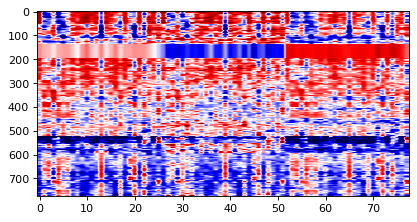

In [13]:
%matplotlib inline
plt.figure(dpi=80)
from scipy.cluster.hierarchy import leaves_list, linkage
ss = StandardScaler()
x_scaled = ss.fit_transform(X)
Z = linkage(x_scaled, 'ward')
plt.imshow(x_scaled[leaves_list(Z), :], aspect=0.05, cmap='seismic', vmax=2, vmin=-2)

If we reduce the number of features to 10 using PCA, we can kind of see two equally sized groups emerge.

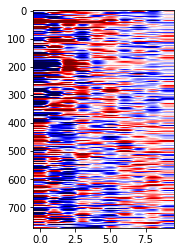

In [19]:
%matplotlib inline
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pcs = pca.fit_transform(x_scaled)
plt.imshow(pcs, aspect=0.02,cmap='seismic', vmax=2, vmin=-2)

There is not any single feature that completely separate the groups, but most the distributions of most features are different between the two.

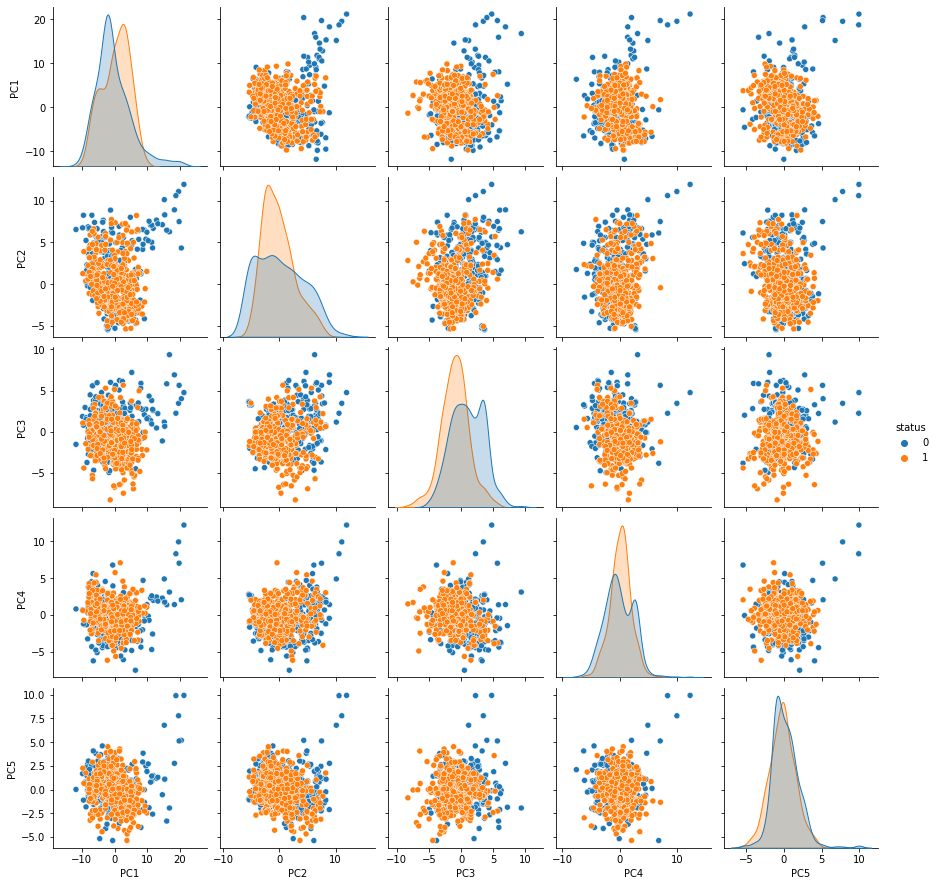

In [20]:
%matplotlib inline
import seaborn as sns
pcs_df = pd.DataFrame(pcs[:, :5])
pcs_df.columns = [f'PC{i+1}' for i in range(pcs_df.shape[1])]
pcs_df['status'] = y.values
sns.pairplot(data=pcs_df, hue='status')

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

# Random forests rely on ranks, no need to standardize
X_train, X_test, y_train, y_test = train_test_split(X, loops['status'], test_size=0.20)
pl = Pipeline([
    ('forest', RandomForestClassifier())]
)
# Search for optimal parameters (uses 5-fold cv for validation by default)
params = {
    'forest__n_estimators': [50, 100, 200],
    'forest__max_depth': [10, 30, None],
}
gs = GridSearchCV(pl, param_grid=params, verbose=True, n_jobs=12)
gs.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=Pipeline(steps=[('forest', RandomForestClassifier())]),
             n_jobs=12,
             param_grid={'forest__max_depth': [10, 30, None],
                         'forest__n_estimators': [50, 100, 200]},
             verbose=True)

<AxesSubplot:ylabel='Frequency'>

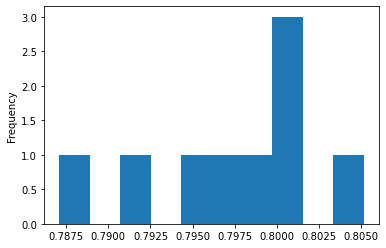

In [39]:
pd.DataFrame(gs.cv_results_).mean_test_score.plot(kind='hist')

In [40]:
gs.best_params_

{'forest__max_depth': None, 'forest__n_estimators': 100}

Best classification score obtained with default parameters of random forest, feature selection and preprocessing only reduced performance. That makes sense, RF basically do feature selection when selecting splits, and rely on ranks. 81.5% accuracy on LOO cross validation, not great, not bad.

In [42]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
loo = LeaveOneOut()
correct = 0
preds = []
x = X.to_numpy()
for train_idx, test_idx in loo.split(x):
    X_train, X_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    pl.fit(X_train, y_train)
    preds.append(pl.predict(X_test))

print(accuracy_score(y, preds))

0.8154838709677419
